In [1]:
import mujoco
from anytree import Node, RenderTree

In [2]:
model = mujoco.MjModel.from_xml_path('../assets/mujoco_menagerie/unitree_a1/a1.xml')

## Build a body tree

In [84]:
bodies = []

# Name's not present here, extracting manually
def extract_name(names):
    return names.decode("utf-8").split('\0')[0]

for i in range(0, model.nbody):
    bodies.append({
        'mj_body': model.body(i), 
        'name': extract_name(model.names[model.name_bodyadr[i]:]),
        'id': i,
        'geom': None,
        }
    )
    

In [68]:
mj_bodies = []

def fill_children(node):
    for b in bodies:
        if (b['mj_body'].parentid == node.data['id']) and (b['mj_body'].parentid != b['id']):
            fill_children(Node(b['name'], data=b, parent=node))
    return node

for body in filter(lambda x: x['mj_body'].parentid == 0, bodies):
    mj_bodies.append(fill_children(Node(body['name'], data=body)))


Here's how body tree looks like

In [69]:
for pre, fill, node in RenderTree(mvj_bodies[1]):
    print("%s%s" % (pre, node.name))

trunk
├── FR_hip
│   └── FR_thigh
│       └── FR_calf
├── FL_hip
│   └── FL_thigh
│       └── FL_calf
├── RR_hip
│   └── RR_thigh
│       └── RR_calf
└── RL_hip
    └── RL_thigh
        └── RL_calf


## Find render bodies

In [61]:
geoms = []

for i in range(0, model.ngeom):
    geoms.append({
        'mj_geom': model.geom(i),
        'name': extract_name(model.names[model.name_geomadr[i]:]),
        'id': i,
        }
    )


`name_geomadr` is broken in python API, all references are 0-terminated strings, while C api is fine in that regard

In [70]:
model.name_geomadr

array([280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292,
       293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305,
       306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318,
       319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329])

So render bodies are found by iterating over all bodies and checking if they group id in 0, 1, 2. Is there a better way?

In [76]:
def fill_geoms(node):
    filtered_geoms = list(filter(lambda x: x['mj_geom'].bodyid == node.data['id'] and x['mj_geom'].group[0] in (0, 1, 2), geoms))
    geom = sorted(filtered_geoms, key=lambda x: x['mj_geom'].group, reverse=True)[0]
    node.data['geom'] = geom
    for child in node.children:
        fill_geoms(child)

fill_geoms(mj_bodies[1])

## Let's render

In [149]:
from vedo import *
import numpy as np
import quaternion

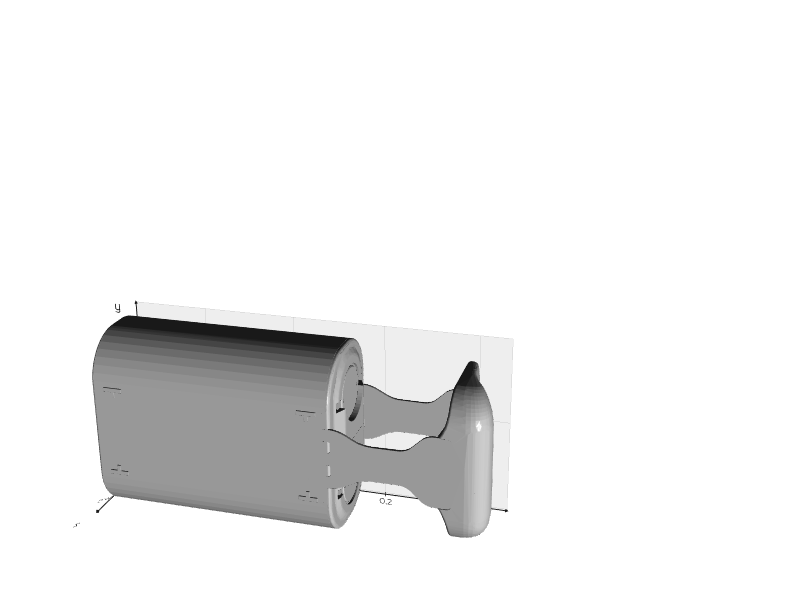

In [160]:
MODEL_DIR = "../assets/mujoco_menagerie/unitree_a1/assets/"

p1 = Point([1, 0, 1], c="white")
l1 = Light(p1, c="white")


def render_body(body):
    geom_path = MODEL_DIR + body.data['name'] + '.obj'
    mesh = Mesh(geom_path)
    mesh.c("white").lighting("glossy")

    mj_geom = body.data['geom']['mj_geom']
    mj_body = body.data['mj_body']

    # print(mj_geom, mj_body)

    mesh.pos(np.array(mj_geom.pos) + np.array(mj_body.pos))
    
    body_quat = np.quaternion(mj_body.quat[0], mj_body.quat[1], mj_body.quat[2], mj_body.quat[3])
    geom_quat = np.quaternion(mj_geom.quat[0], mj_geom.quat[1], mj_geom.quat[2], mj_geom.quat[3])

    quat = body_quat * geom_quat
    euler = quaternion.as_euler_angles(quat)

    mesh.rotate_x(euler[0])
    mesh.rotate_y(euler[1])
    mesh.rotate_z(euler[2])
    


    show(mesh, l1, camera={'pos':(0.5,0.5,1.4)}, axes=True)



render_body(mj_bodies[1])